### Denoising Diffusion Probablisic Models on MNIST digis

#### Libraries

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
import keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras, einsum
from keras import Model, Sequential
from keras.layers import Layer

#### Forward Pass

In [47]:
# hyperparams
image_size = (32, 32)
num_channel = 1
batch_size = 64
timesteps = 200

# seed
np.random.seed(0)

In [48]:
# get and preprocess dataset
def preprocess(x, _):
    return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, (32, 32))

dataset = tfds.load('mnist', as_supervised=True, split="train")
dataset = dataset.map(preprocess, tf.data.AUTOTUNE)
dataset = dataset.shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
dataset = tfds.as_numpy(dataset)

In [49]:
# define forward pass

'''create variance schedule Beta for t = 1,..,200'''
beta = np.linspace(0.0001, 0.02, timesteps)

'''define alpha for representation trick'''
alpha = 1 - beta
a = np.concatenate((np.array([1.]), np.cumprod(alpha, 0)[:-1]), axis=0) # alpha bar

'''define forward pass'''
def forward(x_0, t):
    noise_t = np.random.normal(size=x_0.shape)
    sqrt_a_t = np.reshape(np.take(np.sqrt(a), t), (-1, 1, 1, 1))
    sqrt_one_minus_a_t = np.reshape(np.take(np.sqrt(1-a), t), (-1, 1, 1, 1))
    x_t = sqrt_a_t  * x_0 + sqrt_one_minus_a_t  * noise_t
    return noise_t, x_t

2023-04-17 15:50:58.445202: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


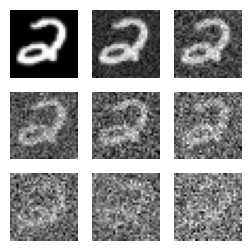

In [50]:
# visualize forward pass

'''show 4x5 images'''
def show_img(x_0, steps):
    plt.figure(figsize=(3,3))
    for i, t in enumerate(steps):
        _, x_t = forward(np.expand_dims(x_0, 0), np.array([t,]))
        plt.subplot(3, 3, i+1)
        plt.imshow(np.squeeze(np.squeeze(x_t,-1),0), cmap='gray')
        plt.axis('off')
    plt.show()

x_0 = next(iter(dataset))[0]
show_img(x_0, [i if i != 200 else 199 for i in range(0,201,25)])


### Reverse (denoising) Pass using U-Net + time embeddings + attention layers